# 공손함 문장 분류 모델에 GloVe 벡터 적용
- 데이터 : Stanford_politeness_corpus
- CNN을 이용해서 문장을 여러 카테고리 중 하나로 분류하는 모델 생성, 미리 학습된 단어 벡터를 모델에 적용
- GloVe : 단어 단위 임베딩 방법으로, 단어벡터공간 상에서 연산을 통한 의미 표현을 주요 목표로 갖고 있음 (단어간 동시 발생 비율을 벡터 공간 상 표시)


In [ ]:
#관련 라이브러리 불러오기
import os
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#Stanford 대학에서 구성한 공손함 데이터
if not os.path.exists("Stanford_politeness_corpus.zip"):
  !wget http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip

if not os.path.exists("Stanford_politeness_corpus/wikipedia.annotated.csv"):
  !unzip Stanford_politeness_corpus.zip



```load_data(data_file):``` 함수로 데이터 불러오기
- bottom quartile (공손하지 않음): 하위 25% (0으로 마킹)
- top quartile (공손함): 상위 25% (1로 마킹)
- neutral (중립적): (2로 마킹)

In [ ]:
def load_data(data_file):
  data = pd.read_csv(data_file)

  # Only use the top quartile as polite, and bottom quartile as impolite. Discard the rest.
  quantiles = data["Normalized Score"].quantile([0.25, 0.5, 0.75])
  print(quantiles)

  for i in range(len(data)):
    score = data.loc[i, "Normalized Score"]
    if score <= quantiles[0.25]:
      # Bottom quartile (impolite).
      data.loc[i, "Normalized Score"] = 0
    elif score >= quantiles[0.75]:
      # Top quartile (polite).
      data.loc[i, "Normalized Score"] = 1
    else:
      # Neutral.
      data.loc[i, "Normalized Score"] = 2

  data["Normalized Score"] = data["Normalized Score"].astype(int)

  # Discard neutral examples.
  data = data[data["Normalized Score"] < 2] #0(impolite)과 1(polite)만 가져감
  data = data.sample(frac=1).reset_index(drop=True)

  return data

In [ ]:
data = load_data("Stanford_politeness_corpus/wikipedia.annotated.csv")
pd.set_option('display.max_columns', None)

data.head()

0.25   -0.442633
0.50    0.052339
0.75    0.514399
Name: Normalized Score, dtype: float64


,Community,Id,Request,Score1,Score2,Score3,Score4,Score5,TurkId1,TurkId2,TurkId3,TurkId4,TurkId5,Normalized Score
0,Wikipedia,393254,"Oh that's charming, so instead of making a per...",5,7,6,5,2,A233ONYNWKDIYF,AO5E3LWBYM72K,A3LXBP8T6JMY9B,A204JAK7QRDWVM,A1KC138MX47DXA,0
1,Wikipedia,423536,"And what, may I ask, is ''your'' relationship ...",1,19,12,9,9,A1R4VG71V6XECZ,A2ULMYRKQMNNFG,A2UBXHCHM2I6IL,A1F4D2PZ7NNWTL,A13CO3B2BRXQLZ,0
2,Wikipedia,28255,If the deleted image only has a single charact...,17,17,25,17,20,A233ONYNWKDIYF,AEWF3138PFWEN,A1GWSZ4I2QGCNJ,A2ULMYRKQMNNFG,AZ1RJVNOZFIWV,1
3,Wikipedia,200038,I was just reminded of my offer to generate a ...,19,21,13,13,17,ANGX5PAAYGL9P,AVWFW00UYDVUD,A1BJTTNDDFZ3ZP,A1TLLJDX8H4JP1,A1F4D2PZ7NNWTL,1
4,Wikipedia,351042,Hmm. Over?,9,12,13,11,9,A233ONYNWKDIYF,AYG3MF094634L,A1F4D2PZ7NNWTL,AZ1RJVNOZFIWV,AZOAW8JH5HJJK,0


In [ ]:
data.loc[:,['Id', 'Request', 'Normalized Score']]

,Id,Request,Normalized Score
0,393254,"Oh that's charming, so instead of making a per...",0
1,423536,"And what, may I ask, is ''your'' relationship ...",0
2,28255,If the deleted image only has a single charact...,1
3,200038,I was just reminded of my offer to generate a ...,1
4,351042,Hmm. Over?,0
...,...,...,...
2173,83789,"OK, I've started the deletion debate at <url>....",1
2174,621291,Why do you ask me questions to which you alrea...,0
2175,332363,Fair enough on the general murder victims. But...,0
2176,619630,Do you know how to make the 'All Star Template...,1


## 단어임베딩

다음으로 할 일은 사전을 구성하는 것입니다.

신경망의 입력으로 사용하기 위해서는 문장을 숫자로 바꿔야 하는데, 사전의 역할은 단어를 숫자로, 숫자를 단어로 바꿔주는 것입니다. (단어 임베딩의 역할)
- 빠른 계산을 위해 dictionary 자료구조 사용

1. 문장들을 소문자로 바꾸고, tokenization (nltk.tokenize 패키지의 word_tokenize 함수 활용)
2. 전체 데이터에서 각 토큰들의 등장 빈도 확인 (collections 패키지의 Counter 클래스 활용)
3. 가장 등장 빈도가 높은 단어를 vocab_size 만큼 선택 (Counter의 most_common 함수 활용)
4. 각각의 단어에 고유한 숫자 부여. 이때, 0번째 토큰은 "
5. 토큰 -> 숫자 변환을 위한 dictionary (word_index 변수에 할당)
<br>숫자 -> 토큰 변환을 위한 dictionary (word_inverted_index 변수에 할당) 생성

In [ ]:
#1) 정규표현식 (문자 제거)
import re

#텍스트 정제 함수: 문자는 모두 제거
def text_cleaning(text):
    hangul = re.compile('[^a-zA-z]') #영어와 띄어쓰기를 제외한 모든 글자 
    #hangul = re.compile('[^ \u3131-\u3163\uac00-\ud7a3]+') 위와 동일
    result = hangul.sub(' ', str(text))
    return(result)

In [ ]:
for i in range(len(data)):
  data.loc[i, 'Request'] = text_cleaning(data['Request'][i])
  
data.loc[:,['Id', 'Request', 'Normalized Score']]

,Id,Request,Normalized Score
0,393254,Oh that s charming so instead of making a per...,0
1,423536,And what may I ask is your relationship ...,0
2,28255,If the deleted image only has a single charact...,1
3,200038,I was just reminded of my offer to generate a ...,1
4,351042,Hmm Over,0
...,...,...,...
2173,83789,OK I ve started the deletion debate at url ...,1
2174,621291,Why do you ask me questions to which you alrea...,0
2175,332363,Fair enough on the general murder victims But...,0
2176,619630,Do you know how to make the All Star Template...,1


In [ ]:
vocab_size = 5000
# we assign the first indices in the vocabulary to special tokens that we use
# for padding, and for indicating unknown words
pad_id = 0
oov_id = 1
index_offset = 1

#사전 구성(단어집)
def make_vocab(sentences):
  word_counter = Counter()

  for sent in sentences:
    tokens = word_tokenize(sent.lower()) #소문자로 바꿔주기
    word_counter.update(tokens) #tokenization
  
  most_common = word_counter.most_common() #등장빈도 확인 후 가장 고빈도의 단어 선택
  print("고빈도 단어:")
  for k, v in most_common[:10]:
    print(k, ": ", v)
  
  vocab = { #각 단어에 고유한 숫자 번호 부여(pad_id, oov_id)
      '<PAD>': pad_id,
      '<OOV>': oov_id
  }
  for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
    vocab[word] = i
    if len(vocab) >= vocab_size:
      break
  
  return vocab
  
sentences = data["Request"].tolist()
word_index = make_vocab(sentences)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
  print(i, word_inverted_index[i])
  
print("\n단어 사전 크기: ", len(word_index))

고빈도 단어:
the :  2506
you :  2241
to :  1702
i :  1694
a :  1140
it :  964
that :  936
of :  860
and :  798
is :  778

단어 사전:
0 <PAD>
1 <OOV>
2 the
3 you
4 to
5 i
6 a
7 it
8 that
9 of

단어 사전 크기:  5000


In [ ]:
def index_to_text(indexes): #숫자 -> 토큰
  return ' '.join([word_inverted_index[i] for i in indexes])
  
def text_to_index(text): #토큰 -> 숫자
  tokens = tokens = word_tokenize(text.lower())
  indexes = []
  for tok in tokens:
    if tok in word_index:
      indexes.append(word_index[tok])
    else:
      indexes.append(oov_id)
      
  return indexes

print("원본: ", sentences[0])
ids = text_to_index(sentences[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  Oh that s charming  so instead of making a personal attack on a single editor you made it on a class of editors  Does that somehow make it more ok 
문자 -> 숫자:  [406, 8, 22, 1746, 42, 250, 9, 300, 6, 356, 488, 15, 6, 515, 267, 3, 103, 7, 15, 6, 546, 9, 340, 79, 8, 1337, 96, 7, 69, 104]
숫자 -> 문자:  oh that s charming so instead of making a personal attack on a single editor you made it on a class of editors does that somehow make it more ok


숫자로 바뀐 문장들을 학습 데이터로 사용할 수 있도록 변형하겠습니다.

1. 모든 문장들을 동일한 길이가 되도록 padding 처리하거나 자름 (tensorflow.python.keras.preprocessing.sequence 패키지의 pad_sequence 함수 활용)
2. 데이터의 일부(10%)를 테스트 데이터로 분리

In [ ]:
x_variable = [text_to_index(sent) for sent in sentences]

#모든 문장 동일한 길이 -> padding 처리
sentence_size = 200
x_padded = pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

#data셋 중에서 10%만 테스트 데이터로 분리
n_test = len(data) // 10
test_inputs = x_padded[:n_test]
train_inputs = x_padded[n_test:]

ys = np.array(data["Normalized Score"].tolist())
test_labels = ys[:n_test]
train_labels = ys[n_test:]

print("test_inputs shape: ", test_inputs.shape)
print("train_inputs shape: ", train_inputs.shape)
print("test_labels shape: ", test_labels.shape)
print("train_labels shape: ", train_labels.shape)

test_inputs shape:  (217, 200)
train_inputs shape:  (1961, 200)
test_labels shape:  (217,)
train_labels shape:  (1961,)


keras.Sequential을 이용하여 CNN 모델을 구성해봅시다. Sequential 모델을 사용하려면 동일한 크기의 필터만 사용할 수 있습니다.

참고 함수:
- keras.layers.Embedding
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding (단어 임베딩 계층)

- keras.layers.Conv1D
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D (Convolutional 계층)

- keras.layers.GlobalMaxPool1D
https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D (Pooling 계층)

- keras.layers.Dense
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense <br>
(Dense 계층, input/output shape를 특정짓는 계층)

## 모델1: 기본 CNN

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [ ]:
#학습 결과 시각화
def plot_loss(history):
  plt.figure(figsize=(6,5))
  val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
  plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend()

  plt.xlim([0,max(history.epoch)])

#성능 측정
def eval_model(model):
  test_loss, test_acc = model.evaluate(test_inputs, test_labels)
  print('Test accuracy:', test_acc)

Epoch 1/10
62/62 [==============================] - 2s 20ms/step - loss: 0.6853 - accuracy: 0.6145 - val_loss: 0.6696 - val_accuracy: 0.6728
Epoch 2/10
62/62 [==============================] - 1s 17ms/step - loss: 0.6033 - accuracy: 0.8480 - val_loss: 0.5803 - val_accuracy: 0.7604
Epoch 3/10
62/62 [==============================] - 1s 17ms/step - loss: 0.4495 - accuracy: 0.8740 - val_loss: 0.5009 - val_accuracy: 0.7742
Epoch 4/10
62/62 [==============================] - 1s 17ms/step - loss: 0.2985 - accuracy: 0.9215 - val_loss: 0.4821 - val_accuracy: 0.7788
Epoch 5/10
62/62 [==============================] - 1s 17ms/step - loss: 0.1906 - accuracy: 0.9597 - val_loss: 0.4884 - val_accuracy: 0.7696
Epoch 6/10
62/62 [==============================] - 1s 17ms/step - loss: 0.1170 - accuracy: 0.9796 - val_loss: 0.5072 - val_accuracy: 0.7558
Epoch 7/10
62/62 [==============================] - 1s 16ms/step - loss: 0.0697 - accuracy: 0.9934 - val_loss: 0.5201 - val_accuracy: 0.7604
Epoch 8/10
62

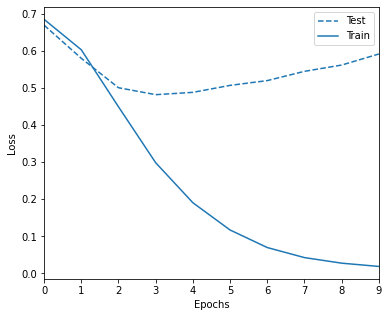

In [ ]:
#모델 학습
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)

## 모델2: CNN, GloVe 사용
**사전 학습된 단어 임베딩 모델 (GloVe) 사용**

In [ ]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip
    
! head glove.6B.50d.txt

GloVe 벡터를 불러와서 임베딩 행렬을 초기화해보겠습니다.

1. GloVe 파일을 읽고, 각 줄에서 단어(1번째 토큰)와 벡터를 이루는 숫자들(2번째 이후 토큰들)을 분리
2. 벡터를 이루는 숫자들을 numpy 행렬로 변환 (numpy의 asarray 함수 활용)
3. 단어와 벡터를 연결하는 dictionary 자료구조 구성 (단어 -> 벡터)
4. 모든 단어들에 대한 임베딩 행렬을 무작위로 생성 (vocab_size X 50 크기의 numpy 행렬)
5. 임베딩 행렬에서, GloVe 벡터가 존재하는 단어들만 해당 GloVe 벡터로 대체

In [ ]:
def load_glove_embeddings(path):
    embeddings = {} #dictionary 구조
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0] #단어
            vectors = np.asarray(values[1:], dtype='float32') #숫자들 numpy 행렬로 변환
            embeddings[w] = vectors #단어와 숫자 연결

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, 50)) #임베딩 행렬 생성
    num_loaded = 0
    for w, i in word_index.items(): #GloVe 벡터가 존재하는 단어 -> GloVe 벡터로 대체
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt')

Successfully loaded pretrained embeddings for 4632/5000 words.


앞서 사용된 모델에서, Embedding layer의 값을 위에서 생성한 임베딩 행렬로 초기화해봅시다. (`keras.initializers.Constant` 클래스 활용)

초기값 설정은 케라스 레이어의 초기 난수 가중치를 설정하는 방식을 규정합니다.

In [ ]:
glove_init = keras.initializers.Constant(embedding_matrix)

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50, embeddings_initializer=glove_init),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

Epoch 1/10
62/62 [==============================] - 3s 39ms/step - loss: 0.8345 - accuracy: 0.5538 - val_loss: 0.6554 - val_accuracy: 0.5899
Epoch 2/10
62/62 [==============================] - 2s 37ms/step - loss: 0.5873 - accuracy: 0.6961 - val_loss: 0.6157 - val_accuracy: 0.6728
Epoch 3/10
62/62 [==============================] - 2s 32ms/step - loss: 0.4939 - accuracy: 0.7894 - val_loss: 0.5853 - val_accuracy: 0.6912
Epoch 4/10
62/62 [==============================] - 2s 40ms/step - loss: 0.4197 - accuracy: 0.8455 - val_loss: 0.5661 - val_accuracy: 0.7189
Epoch 5/10
62/62 [==============================] - 1s 19ms/step - loss: 0.3493 - accuracy: 0.8980 - val_loss: 0.5377 - val_accuracy: 0.7327
Epoch 6/10
62/62 [==============================] - 1s 19ms/step - loss: 0.2860 - accuracy: 0.9322 - val_loss: 0.5212 - val_accuracy: 0.7696
Epoch 7/10
62/62 [==============================] - 1s 19ms/step - loss: 0.2383 - accuracy: 0.9470 - val_loss: 0.5180 - val_accuracy: 0.7558
Epoch 8/10
62

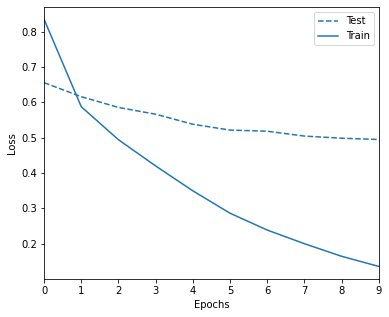

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)

## 모델3: CNN, GloVe, Dropout

In [ ]:
from keras.layers import Embedding, Dense, Flatten, Dropout
glove_init = keras.initializers.Constant(embedding_matrix)

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50, embeddings_initializer=glove_init),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

Epoch 1/10
62/62 [==============================] - 2s 23ms/step - loss: 0.7699 - accuracy: 0.5375 - val_loss: 0.6500 - val_accuracy: 0.5991
Epoch 2/10
62/62 [==============================] - 1s 20ms/step - loss: 0.6122 - accuracy: 0.6583 - val_loss: 0.6126 - val_accuracy: 0.6313
Epoch 3/10
62/62 [==============================] - 1s 21ms/step - loss: 0.5278 - accuracy: 0.7450 - val_loss: 0.5847 - val_accuracy: 0.6406
Epoch 4/10
62/62 [==============================] - 1s 20ms/step - loss: 0.4511 - accuracy: 0.8108 - val_loss: 0.5799 - val_accuracy: 0.6774
Epoch 5/10
62/62 [==============================] - 1s 20ms/step - loss: 0.3790 - accuracy: 0.8536 - val_loss: 0.5444 - val_accuracy: 0.6866
Epoch 6/10
62/62 [==============================] - 1s 20ms/step - loss: 0.3331 - accuracy: 0.8797 - val_loss: 0.5172 - val_accuracy: 0.7143
Epoch 7/10
62/62 [==============================] - 1s 20ms/step - loss: 0.2864 - accuracy: 0.9036 - val_loss: 0.4944 - val_accuracy: 0.7419
Epoch 8/10
62

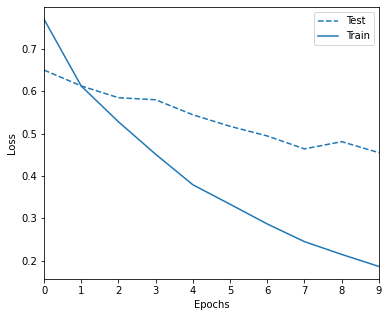

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)

## 모델4: RNN

In [ ]:
from keras.layers import Embedding, Dense, Flatten, Dropout, SimpleRNN
glove_init = keras.initializers.Constant(embedding_matrix)

modelr = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50, embeddings_initializer=glove_init),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

Epoch 1/10
16/16 [==============================] - 2s 87ms/step - loss: 0.7419 - accuracy: 0.4824 - val_loss: 0.7123 - val_accuracy: 0.4931
Epoch 2/10
16/16 [==============================] - 1s 72ms/step - loss: 0.7001 - accuracy: 0.5033 - val_loss: 0.6940 - val_accuracy: 0.5069
Epoch 3/10
16/16 [==============================] - 1s 71ms/step - loss: 0.6934 - accuracy: 0.5059 - val_loss: 0.6934 - val_accuracy: 0.4931
Epoch 4/10
16/16 [==============================] - 1s 71ms/step - loss: 0.6962 - accuracy: 0.4936 - val_loss: 0.6958 - val_accuracy: 0.4931
Epoch 5/10
16/16 [==============================] - 1s 70ms/step - loss: 0.6938 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5069
Epoch 6/10
16/16 [==============================] - 1s 72ms/step - loss: 0.6943 - accuracy: 0.4890 - val_loss: 0.6931 - val_accuracy: 0.5069
Epoch 7/10
16/16 [==============================] - 1s 74ms/step - loss: 0.6939 - accuracy: 0.5008 - val_loss: 0.6952 - val_accuracy: 0.4931
Epoch 8/10
16

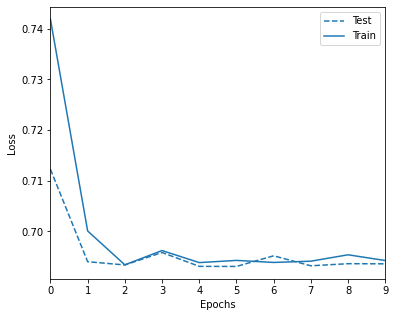

In [ ]:
modelr.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = modelr.fit(train_inputs,
          train_labels,
          epochs=10,
          batch_size = 128,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(modelr)